# License

Copyright 2020 Hamaad Musharaf Shah

Licensed under the Apache License, Version 2.0 (the "License"); you may not use this file except in compliance with the License. You may obtain a copy of the License at

http://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software distributed under the License is distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. See the License for the specific language governing permissions and limitations under the License.

# Using Bidirectional Generative Adversarial Networks to estimate Value-at-Risk for Market Risk Management
## Author: Hamaad Shah

---

We will explore the use of Bidirectional Generative Adversarial Networks (BiGAN) for market risk management: Estimation of portfolio risk measures such as Value-at-Risk (VaR). Generative Adversarial Networks (GAN) allow us to implicitly maximize the likelihood of complex distributions thereby allowing us to generate samples from such distributions - the key point here is the implicit maximum likelihood estimation principle whereby we do not specify what this complex distribution is parameterized as. Dealing with high dimensional data potentially coming from a complex distribution is a key aspect to market risk management among many other financial services use cases. GAN, specifically BiGAN for the purpose of this paper, will allow us to deal with potentially complex financial services data such that we do not have to explicitly specify a distribution such as a multidimensional Gaussian distribution.

## Market Risk Management: Value-at-Risk (VaR)

---

VaR is a measure of portfolio risk. For instance, a 1% VaR of -5% means that there is a 1% chance of earning a portfolio return of less than -5%. Think of it as a (lower) percentile or quantile of a portfolio returns distribution, i.e., we are concerned about the tail risk — the small chance of losing a remarkably large portfolio value. Such a large loss is funded by our own funds, i.e., capital which is an expensive source of funding compared to other peoples’ funds, i.e., debt. Therefore the estimation of VaR and similar market risk management measures inform banks and insurance firms with regards to the levels of capital they need to hold in order to have a buffer against unexpected downturns — market risk.

For our purpose, let us begin by fetching a data set of 5 stocks from Yahoo. The stocks are Apple, Google, Microsoft, Intel and Box. We use a daily frequency for our data for the year 2016. We use the stock's daily closing prices to compute the continuously compounded returns: $\log\left(\frac{V_{t+1}}{V_{t}}\right) = \log(V_{t+1}) - \log(V_{t})$.

![](../R/portfolio_returns.png)

Let's estimate the expected returns vector, volatilities vector, correlation and variance-covariance matrices. The variance-covariance matrix is recovered from the estimated volatilities vector and correlation matrix: $\Omega = C \odot \sigma \sigma^{T}$ where $\odot$ is the Hadamard product, $C \in \mathbb{R}^{5 \times 5}$ and $\sigma \in \mathbb{R}^{5 \times 1}$. Portfolio volatility is estimated as: $w^{T}\Omega w$ where $w \in \mathbb{R}^{5 \times 1}$

We consider the 3 major methods used in market risk management, specifically for the estimation of VaR. Please note that there are multiple different methods for estimating VaR and other more coherent risk measures such as Conditional Value-at-Risk (CVaR) however we are only considering the few major ones.

## VaR: Variance-covariance method

---

The first one is the variance-covariance method and uses the estimated portfolio volatility $w^{T}\Omega w$ under the Gaussian assumption to estimate VaR. Let's assume we are attempting to estimate 1% VaR: This means that there is a 1% probability of obtaining a portfolio return of less than the VaR value. Using the variance-covariance approach the calculation is: $\left[\left(w^{T}\Omega w\right) \mathcal{N}^{-1}(1\%)\right] + w^{T}\mu$, where $\mu \in \mathbb{R}^{5 \times 1}$ is the expected returns vector.

## VaR: Historical simulation method
The second method is a non-parametric approach where we sample with replacement from the historical data to estimate a portfolio returns distribution. The 1% VaR is simply the appropriate quantile from this sampled portfolio returns distribution.

## VaR: Monte Carlo method

---

The third method is Monte Carlo sampling from a multidimensional Gaussian distribution using the aforementioned $mu$ and $\Omega$ parameters. Finally the 1% VaR is simply the appropriate quantile from this sampled portfolio returns distribution.

## VaR: Estimates
The VaR estimates from the aforementioned 3 market risk management methods commonly used in banking are as follows:

| VaR Method    | 1% VaR | 
| :------------- |-------------:|
| Variance-covariance | -2.87% | 
| Historical simulation | -3.65%  |
| Monte Carlo simulation | -2.63%  |

## Bidirectional Generative Adversarial Network (BiGAN)

---

The 2 main components to a Generative Adversarial Network (GAN) are the generator and the discriminator. These 2 components play an adversarial game against each other. In doing so the generator learns how to create realistic synthetic samples from noise, i.e., the latent space $z$, while the discriminator learns how to distinguish between a real sample and a synthetic sample. See the following article of mine for a detailed explanation of GAN: https://goo.gl/ZWYngw

BiGAN extends GAN by adding a third component: The encoder, which learns to map from data space $x$ to the latent space $z$. The objective of the generator remains the same while the objective of the discriminator is altered to classify between a real sample and a synthetic sample and additionally between a real encoding, i.e., given by the encoder, and a synthetic encoding, i.e., a sample from the latent space $z$.

### Generator

---

Assume that we have a prior belief on where the latent space $z$ lies: $p_{Z}(z)$. Given a draw from this latent space the generator $G$, a deep learner parameterized by $\theta_{G}$, outputs a synthetic sample.

$$
G(z|\theta_{G}): z \rightarrow x_{synthetic}
$$ 

### Encoder

---

This can be shown to be an inverse of the generator. Given a draw from the data space the encoder $E$, a deep learner parameterized by $\theta_{E}$, outputs a real encoding.

$$
E(x|\theta_{E}): x \rightarrow z
$$ 

### Discriminator

---

The discriminator $D$ is a deep learner parameterized by $\theta_{D}$ and it aims to classify if a sample is real or synthetic, i.e., if a sample is from the real data distribution,

$$
p_{X}(x)
$$ 

or the synthetic data distribution.

$$
p_{G}(x|z)
$$

Additionally it aims to classify whether an encoding is real,

$$
p_{E}(z|x)
$$

or synthetic.

$$
p_{Z}(z) 
$$

Let us denote the discriminator $D$ as follows.

$$
D(\{x, z\}|\theta_{D}): \{x, z\} \rightarrow [0, 1]
$$ 

We assume that the positive examples are real, i.e., $\{x, E(x|\theta_{E})\}$ while the negative examples are synthetic, i.e., $\{G(z|\theta_{G}), z\}$. 

### Optimal discriminator, encoder and generator

---

The BiGAN has the following objective function, similar to the GAN.

$$
\min_{G(z|\theta_{G}), E(x|\theta_{E})} \max_{D(\{x, z\}|\theta_{D})} V(D(\{x, z\}|\theta_{D}), G(z|\theta_{G}), E(x|\theta_{E}))
$$

\begin{align*}
V(D(\{x, z\}|\theta_{D}), G(z|\theta_{G}), E(x|\theta_{E})) &= \mathbb{E}_{x \sim p_{X}(x)} \mathbb{E}_{z \sim p_{E}(z|x)} \log\left[{D(\{x, z\}|\theta_{D})}\right] + \mathbb{E}_{z \sim p_{Z}(z)} \mathbb{E}_{x \sim p_{G}(x|z)} \log\left[{1-D(\{x, z\}|\theta_{D})}\right] \\
&= \int_{x} p_{X}(x) \int_{z} p_{E}(z|x) \log\left[{D(\{x, z\}|\theta_{D})}\right] dz dx + \int_{z} p_{Z}(z) \int_{x} p_{G}(x|z) \log\left[{1 - D(\{x, z\}|\theta_{D})}\right] dx dz \\
&= \int_{\{x, z\}} p_{X}(x) p_{E}(z|x) \log\left[{D(\{x, z\}|\theta_{D})}\right] d\{x, z\} + \int_{\{x, z\}} p_{Z}(z) p_{G}(x|z) \log\left[{1 - D(\{x, z\}|\theta_{D})}\right] d\{x, z\} \\
&= \int_{\omega:=\{x, z\}} \underbrace{p_{EX}(\omega) \log\left[{D(\omega|\theta_{D})}\right] + p_{GZ}(\omega) \log\left[{1 - D(\omega|\theta_{D})}\right]}_{J(D(\omega|\theta_{D}))} d\omega \\
\end{align*}

Let us take a closer look at the discriminator's objective function for a sample $\omega$.

\begin{align*}
J(D(\omega|\theta_{D})) &= p_{EX}(\omega) \log{D(\omega|\theta_{D})} + p_{GZ}(\omega) \log{(1 - D(\omega|\theta_{D}))} \\
\frac{\partial J(D(\omega|\theta_{D}))}{\partial D(\omega|\theta_{D})} &= \frac{p_{EX}(\omega)}{D(\omega|\theta_{D})} - \frac{p_{GZ}(\omega)}{(1 - D(\omega|\theta_{D}))} \\
0 &= \frac{p_{EX}(\omega)}{D^\ast(\omega|\theta_{D^\ast})} - \frac{p_{GZ}(\omega)}{(1 - D^\ast(\omega|\theta_{D^\ast}))} \\
p_{EX}(\omega)(1 - D^\ast(\omega|\theta_{D^\ast})) &= p_{GZ}(\omega)D^\ast(\omega|\theta_{D^\ast}) \\
p_{EX}(\omega) - p_{EX}(\omega)D^\ast(\omega|\theta_{D^\ast})) &= p_{GZ}(\omega)D^\ast(\omega|\theta_{D^\ast}) \\
p_{GZ}(\omega)D^\ast(\omega|\theta_{D^\ast}) + p_{EX}(\omega)D^\ast(\omega|\theta_{D^\ast})) &= p_{EX}(\omega) \\
D^\ast(\omega|\theta_{D^\ast}) &= \frac{p_{EX}(\omega)}{p_{EX}(\omega) + p_{GZ}(\omega)} 
\end{align*}

We have found the optimal discriminator given a generator and an encoder. Let us focus now on the generator and encoder's objective function which is essentially to minimize the discriminator's objective function.

\begin{align*}
J(G(z|\theta_{G}), E(x|\theta_{E})) &= \mathbb{E}_{\omega \sim p_{EX}(\omega)} \log{D^\ast(\omega|\theta_{D^\ast})} + \mathbb{E}_{\omega \sim p_{GZ}(\omega)} \log{(1 - D^\ast(\omega|\theta_{D^\ast}))} \\
&= \mathbb{E}_{\omega \sim p_{EX}(\omega)} \log{\bigg( \frac{p_{EX}(\omega)}{p_{EX}(\omega) + p_{GZ}(\omega)}} \bigg) + \mathbb{E}_{\omega \sim p_{GZ}(\omega)} \log{\bigg(1 - \frac{p_{EX}(\omega)}{p_{EX}(\omega) + p_{GZ}(\omega)}\bigg)} \\
&= \mathbb{E}_{\omega \sim p_{EX}(\omega)} \log{\bigg( \frac{p_{EX}(\omega)}{p_{EX}(\omega) + p_{GZ}(\omega)}} \bigg) + \mathbb{E}_{\omega \sim p_{GZ}(\omega)} \log{\bigg(\frac{p_{GZ}(\omega)}{p_{EX}(\omega) + p_{GZ}(\omega)}\bigg)} \\
&= \int_{\omega} p_{EX}(\omega) \log{\bigg( \frac{p_{EX}(\omega)}{p_{EX}(\omega) + p_{GZ}(\omega)}} \bigg) d\omega + \int_{\omega} p_{GZ}(\omega) \log{\bigg(\frac{p_{GZ}(\omega)}{p_{EX}(\omega) + p_{GZ}(\omega)}\bigg)} d\omega
\end{align*}

We will note the Kullback–Leibler (KL) divergences in the above objective function for the generator and encoder.

$$
D_{KL}(P||Q) = \int_{x} p(x) \log\bigg(\frac{p(x)}{q(x)}\bigg) dx
$$

Recall the definition of a $\lambda$ divergence.

$$
D_{\lambda}(P||Q) = \lambda D_{KL}(P||\lambda P + (1 - \lambda) Q) + (1 - \lambda) D_{KL}(Q||\lambda P + (1 - \lambda) Q)
$$

If $\lambda$ takes the value of 0.5 this is then called the Jensen-Shannon (JS) divergence. This divergence is symmetric and non-negative.

$$
D_{JS}(P||Q) = 0.5 D_{KL}\bigg(P\bigg|\bigg|\frac{P + Q}{2}\bigg) + 0.5 D_{KL}\bigg(Q\bigg|\bigg|\frac{P + Q}{2}\bigg)
$$

Keeping this in mind let us take a look again at the objective function of the generator and the encoder.

\begin{align*}
J(G(z|\theta_{G}), E(x|\theta_{E})) &= \int_{\omega} p_{EX}(\omega) \log{\bigg( \frac{p_{EX}(\omega)}{p_{EX}(\omega) + p_{GZ}(\omega)}} \bigg) d\omega + \int_{\omega} p_{GZ}(\omega) \log{\bigg(\frac{p_{GZ}(\omega)}{p_{EX}(\omega) + p_{GZ}(\omega)}\bigg)} d\omega \\
&= \int_{\omega} p_{EX}(\omega) \log{\bigg(\frac{2}{2}\frac{p_{EX}(\omega)}{p_{EX}(\omega) + p_{GZ}(\omega)}} \bigg) d\omega + \int_{\omega} p_{GZ}(\omega) \log{\bigg(\frac{2}{2}\frac{p_{GZ}(\omega)}{p_{EX}(\omega) + p_{GZ}(\omega)}\bigg)} d\omega \\
&= \int_{\omega} p_{EX}(\omega) \log{\bigg(\frac{1}{2}\frac{1}{0.5}\frac{p_{EX}(\omega)}{p_{EX}(\omega) + p_{GZ}(\omega)}} \bigg) d\omega + \int_{\omega} p_{GZ}(\omega) \log{\bigg(\frac{1}{2}\frac{1}{0.5}\frac{p_{GZ}(\omega)}{p_{EX}(\omega) + p_{GZ}(\omega)}\bigg)} d\omega \\
&= \int_{\omega} p_{EX}(\omega) \bigg[ \log(0.5) + \log{\bigg(\frac{p_{EX}(\omega)}{0.5 (p_{EX}(\omega) + p_{GZ}(\omega))}} \bigg) \bigg] d\omega \\ &+ \int_{\omega} p_{GZ}(\omega) \bigg[\log(0.5) + \log{\bigg(\frac{p_{GZ}(\omega)}{0.5 (p_{EX}(\omega) + p_{GZ}(\omega))}\bigg) \bigg] } d\omega \\
&= \log\bigg(\frac{1}{4}\bigg) + \int_{\omega} p_{EX}(\omega) \bigg[\log{\bigg(\frac{p_{EX}(\omega)}{0.5 (p_{EX}(\omega) + p_{GZ}(\omega))}} \bigg) \bigg] d\omega \\ 
&+ \int_{\omega} p_{GZ}(\omega) \bigg[\log{\bigg(\frac{p_{GZ}(\omega)}{0.5 (p_{EX}(\omega) + p_{GZ}(\omega))}\bigg) \bigg] } d\omega \\
&= -\log(4) + D_{KL}\bigg(P_{EX}\bigg|\bigg|\frac{P_{EX} + P_{GZ}}{2}\bigg) + D_{KL}\bigg(P_{GZ}\bigg|\bigg|\frac{P_{EX} + P_{GZ}}{2}\bigg) \\
&= -\log(4) + 2 \bigg(0.5 D_{KL}\bigg(P_{EX}\bigg|\bigg|\frac{P_{EX} + P_{GZ}}{2}\bigg) + 0.5 D_{KL}\bigg(P_{GZ}\bigg|\bigg|\frac{P_{EX} + P_{GZ}}{2}\bigg)\bigg) \\
&= -\log(4) + 2D_{JS}(P_{EX}||P_{GZ}) 
\end{align*}

It is clear from the objective function of the generator and encoder above that the global minimum value attained is $-\log(4)$ which occurs when the following holds.

$$
P_{EX}=P_{GZ}
$$

When the above holds the Jensen-Shannon divergence, i.e., $D_{JS}(P_{EX}||P_{GZ})$, will be zero. Hence we have shown that the optimal solution is as follows.

$$
P_{EX}=P_{GZ}
$$

Given the above result we can prove that the optimal discriminator will be $\frac{1}{2}$.

\begin{align*}
D^\ast(\omega|\theta_{D^\ast}) &= \frac{p_{EX}(\omega)}{p_{EX}(\omega) + p_{GZ}(\omega)} \\
 &= \frac{p_{EX}(\omega)}{p_{EX}(\omega) + p_{EX}(\omega)} \\
 &= \frac{p_{EX}(\omega)}{2p_{EX}(\omega)} \\
 &= \frac{1}{2} \\
\end{align*}

### Optimal encoder and generator are inverse functions of each other

---

At the optimal generator and encoder we can show that the generator and encoder are inverse functions of each other. Recall from earlier the definitions of the generator and the encoder.

$$
G(z|\theta_{G}): z \rightarrow x_{synthetic}
$$ 

$$
E(x|\theta_{E}): x \rightarrow z
$$ 

At this point the optimal discriminator is $\frac{1}{2}$, i.e., the discriminator cannot effectively differentiate between real and synthetic data as the synthetic data is realistic. Remember that at this point the likelihood would have been implicitly maximized such that any samples taken from the synthetic distribution should be similar to those taken from the real distribution. In short, if optimality of the generator, encoder and discriminator holds then the synthetic data should look similar, or rather be the same, as the real data. Keeping this important point in mind let's slightly re-write the optimal generator and encoder functions.

$$
G^\ast(z|\theta_{G^\ast}): z \rightarrow x
$$ 

$$
E^\ast(x|\theta_{E^\ast}): x \rightarrow z
$$ 

Recall further that the following holds at the optimal generator and encoder.

\begin{align*}
P_{EX} &= \int_{x} p_{X}(x) \int_{z=E^\ast(x|\theta_{E^\ast})} p_{E^\ast}(z|x) dz dx \\
\end{align*}

In the above please note the following; note also that we make the assumption that the generator is not an inverse function of the encoder for providing a proof by contradiction.

\begin{align*}
z&=E^\ast(x|\theta_{E^\ast}) \\
x&\neq G^\ast(E^\ast(x|\theta_{E^\ast})|\theta_{G^\ast}) \\
\end{align*}

Recall that optimality condition of the generator and encoder.

\begin{align*}
P_{EX} &= P_{GZ} \\
P_{GZ} &= \int_{z} p_{Z}(z) \int_{x=G^\ast(z|\theta_{G^\ast})} p_{G^\ast}(x|z) dx dz \\
\end{align*}

In the above please note the following.

\begin{align*}
x&=G^\ast(z|\theta_{G^\ast}) \\
z&=E^\ast(x|\theta_{E^\ast}) \\
z&=E^\ast(G^\ast(z|\theta_{G^\ast})|\theta_{E^\ast}) \\
G^\ast(z|\theta_{G^\ast})&=G^\ast(E^\ast(G^\ast(z|\theta_{G^\ast})|\theta_{E^\ast})|\theta_{G^\ast}) \\
\end{align*}

If optimality holds then the following holds as shown above.

$$
G^\ast(z|\theta_{G^\ast})=G^\ast(E^\ast(G^\ast(z|\theta_{G^\ast})|\theta_{E^\ast})|\theta_{G^\ast})
$$

However since we assumed that the generator is not an inverse function of the encoder then the above conditions cannot hold thereby violating the optimality condition.

\begin{align*}
x&\neq G^\ast(E^\ast(x|\theta_{E^\ast})|\theta_{G^\ast}) \\
G^\ast(z|\theta_{G^\ast})&\neq G^\ast(E^\ast(G^\ast(z|\theta_{G^\ast})|\theta_{E^\ast})|\theta_{G^\ast}) \\
\end{align*}

Therefore we have shown by contradiction that under optimality of the generator and encoder the generator is an inverse function of the encoder.

\begin{align*}
x&=G^\ast(E^\ast(x|\theta_{E^\ast})|\theta_{G^\ast}) \\
\end{align*}

The same arguments made above can be shown for the encoder being the inverse of the generator.

\begin{align*}
P_{GZ} &= \int_{z} p_{Z}(z) \int_{x=G^\ast(z|\theta_{G^\ast})} p_{G^\ast}(x|z) dx dz \\
\end{align*}

In the above please note the following; note also that we make the assumption that the encoder is not an inverse function of the generator for providing a proof by contradiction.

\begin{align*}
x&=G^\ast(z|\theta_{G^\ast}) \\
z&\neq E^\ast(G^\ast(z|\theta_{G^\ast})|\theta_{E^\ast}) \\
\end{align*}

Recall that optimality condition of the generator and encoder.

\begin{align*}
P_{EX} &= P_{GZ} \\
P_{EX} &= \int_{x} p_{X}(x) \int_{z=E^\ast(x|\theta_{E^\ast})} p_{E^\ast}(z|x) dz dx \\
\end{align*}

In the above please note the following.

\begin{align*}
z&=E^\ast(x|\theta_{E^\ast}) \\
x&=G^\ast(z|\theta_{G^\ast}) \\
x&=G^\ast(E^\ast(x|\theta_{E^\ast})|\theta_{G^\ast}) \\
E^\ast(x|\theta_{E^\ast})&=E^\ast(G^\ast(E^\ast(x|\theta_{E^\ast})|\theta_{G^\ast})|\theta_{E^\ast}) \\
\end{align*}

If optimality holds then the following holds as shown above.

$$
E^\ast(x|\theta_{E^\ast})=E^\ast(G^\ast(E^\ast(x|\theta_{E^\ast})|\theta_{G^\ast})|\theta_{E^\ast})
$$

However since we assumed that the encoder is not an inverse function of the generator then the above conditions cannot hold thereby violating the optimality condition.

\begin{align*}
z&\neq E^\ast(G^\ast(z|\theta_{G^\ast})|\theta_{E^\ast}) \\
E^\ast(x|\theta_{E^\ast})&\neq E^\ast(G^\ast(E^\ast(x|\theta_{E^\ast})|\theta_{G^\ast})|\theta_{E^\ast}) \\
\end{align*}

Therefore we have shown by contradiction that under optimality of the generator and encoder the encoder is an inverse function of the generator.

\begin{align*}
z&= E^\ast(G^\ast(z|\theta_{G^\ast})|\theta_{E^\ast}) \\
\end{align*}

Therefore we have shown that the optimal encoder and generator are inverse functions of each other via proof by contradiction: If they were not inverse functions of each other then it would violate the optimality condition for the encoder and generator, i.e.,  $P_{EX} = P_{GZ}$.

### BiGAN relation to autoencoders

At this point it might be a good idea to review my previous article on autoencoders here: https://goo.gl/qWqbbv

Note that given an optimal discriminator, the objective function of the generator and encoder can be thought of as that of an autoencoder, where the generator plays the role of a decoder. The objective function of the generator and encoder is simply to minimize the objective function of the discriminator, i.e., we have not explicitly specified the structure of the reconstruction loss as one might do so with an autoencoder. This implicit minimization of the reconstruction loss is yet another great advantage of BiGAN: One does not need to explicitly define a reconstruction loss. 

Let's remind ourselves of the objective function of the generator and encoder.

\begin{align*}
J(G(z|\theta_{G}), E(x|\theta_{E})) &= -\log(4) + 2D_{JS}(P_{EX}||P_{GZ}) \\
&= -\log(4) + 2 \bigg(0.5 D_{KL}\bigg(P_{EX}\bigg|\bigg|\frac{P_{EX} + P_{GZ}}{2}\bigg) + 0.5 D_{KL}\bigg(P_{GZ}\bigg|\bigg|\frac{P_{EX} + P_{GZ}}{2}\bigg)\bigg) \\
&= -\log(4) + D_{KL}\bigg(P_{EX}\bigg|\bigg|\frac{P_{EX} + P_{GZ}}{2}\bigg) + D_{KL}\bigg(P_{GZ}\bigg|\bigg|\frac{P_{EX} + P_{GZ}}{2}\bigg) \\
&= \log\bigg(\frac{1}{4}\bigg) + \int_{\omega} p_{EX}(\omega) \bigg[\log{\bigg(\frac{p_{EX}(\omega)}{0.5 (p_{EX}(\omega) + p_{GZ}(\omega))}} \bigg) \bigg] d\omega \\ 
&+ \int_{\omega} p_{GZ}(\omega) \bigg[\log{\bigg(\frac{p_{GZ}(\omega)}{0.5 (p_{EX}(\omega) + p_{GZ}(\omega))}\bigg) \bigg] } d\omega \\
\end{align*}

Let's deal with $F_{EG}$ first and then with $F_{GE}$ second in a similar manner. These are defined as follows.

\begin{align*}
D_{KL}\bigg(P_{EX}\bigg|\bigg|\frac{P_{EX} + P_{GZ}}{2}\bigg) &= \underbrace{\log{2}}_{\text{We can omit this constant for simplicity}} + \int_{\omega} p_{EX}(\omega) \bigg[\log{\bigg(\frac{p_{EX}(\omega)}{(p_{EX}(\omega) + p_{GZ}(\omega))}} \bigg) \bigg] d\omega \\
D_{KL}\bigg(P_{EX}\bigg|\bigg|\frac{P_{EX} + P_{GZ}}{2}\bigg) - \log{2} &= \int_{\omega} \bigg[\log{\bigg(\frac{p_{EX}(\omega)d\omega}{\left[\underbrace{(p_{EX}(\omega) + p_{GZ}(\omega))d\omega}_{d(P_{EX} + P_{GZ})}\right]}} \bigg) \bigg] \underbrace{p_{EX}(\omega) d\omega}_{dP_{EX}} \\
F_{EG} &= \int \bigg[\log{\underbrace{\bigg(\frac{dP_{EX}}{d(P_{EX} + P_{GZ})}\bigg)}_{\text{Radon-Nikodym derivative: }f_{EG}}} \bigg] dP_{EX} \\
F_{EG} &= \int \log{f_{EG}} dP_{EX} \\
\end{align*}

Briefly recall the definition of a Radon-Nikodym derivative: $\frac{d\nu}{d\mu}$.

$$
\nu = \int \frac{d\nu}{d\mu}d\mu
$$

It follows then.

\begin{align*}
P_{EX}(X) &= \int_{X} \frac{dP_{EX}}{d(P_{EX} + P_{GZ})} d(P_{EX} + P_{GZ}) \\
\end{align*}

Now for the second term: $F_{GE}$.

\begin{align*}
D_{KL}\bigg(P_{GZ}\bigg|\bigg|\frac{P_{EX} + P_{GZ}}{2}\bigg) &= \underbrace{\log{2}}_{\text{We can omit this constant for simplicity}} + \int_{\omega} p_{GZ}(\omega) \bigg[\log{\bigg(\frac{p_{GZ}(\omega)}{(p_{EX}(\omega) + p_{GZ}(\omega))}} \bigg) \bigg] d\omega \\
D_{KL}\bigg(P_{GZ}\bigg|\bigg|\frac{P_{EX} + P_{GZ}}{2}\bigg) - \log{2} &= \int_{\omega} \bigg[\log{\bigg(\frac{p_{GZ}(\omega)d\omega}{\left[\underbrace{(p_{EX}(\omega) + p_{GZ}(\omega))d\omega}_{d(P_{EX} + P_{GZ})}\right]}} \bigg) \bigg] \underbrace{p_{GZ}(\omega) d\omega}_{dP_{GZ}} \\
F_{GE} &= \int \bigg[\log{\underbrace{\bigg(\frac{dP_{GZ}}{d(P_{EX} + P_{GZ})}\bigg)}_{\text{Radon-Nikodym derivative: }f_{GE}}} \bigg] dP_{GZ} \\
F_{GE} &= \int \log{f_{GE}} dP_{GZ} \\
\end{align*}

It follows then.

\begin{align*}
P_{GZ}(X) &= \int_{X} \frac{dP_{GZ}}{d(P_{EX} + P_{GZ})} d(P_{EX} + P_{GZ}) \\
\end{align*}

Note also that.

\begin{align*}
f_{EG} + f_{GE} &= \frac{dP_{EX}}{d(P_{EX} + P_{GZ})} + \frac{dP_{GZ}}{d(P_{EX} + P_{GZ})} \\
&= \frac{dP_{EX} + dP_{GZ}}{d(P_{EX} + P_{GZ})} \\
&= \frac{dP_{EX} + dP_{GZ}}{dP_{EX} + dP_{GZ}} \\
&= 1 \\
\end{align*}

Now we shall prove that $f_{EG} > 0$ with $P_{EX}$ almost everywhere. To prove this, assume that $f_{EG} = 0$.

\begin{align*}
P_{EX}(X) &= \int_{X} f_{EG} d(P_{EX} + P_{GZ}) \\
P_{EX}(X) &= \int_{X} 0 d(P_{EX} + P_{GZ}) \\
P_{EX}(X) &= 0 \\
\end{align*}

Therefore, $f_{EG} > 0$ with $P_{EX}$ almost everywhere. This means that $F_{EG}$ is well defined.

Now we shall prove that $f_{GE} > 0$ with $P_{GZ}$ almost everywhere. To prove this, assume that $f_{GE} = 0$.

\begin{align*}
P_{GZ}(X) &= \int_{X} f_{GE} d(P_{EX} + P_{GZ}) \\
P_{GZ}(X) &= \int_{X} 0 d(P_{EX} + P_{GZ}) \\
P_{GZ}(X) &= 0 \\
\end{align*}

Therefore, $f_{GE} > 0$ with $P_{GZ}$ almost everywhere. This means that $F_{GE}$ is well defined.

The $F_{EG}$ outside the support of $P_{GZ}$ is $0$. Similarly, the $F_{GE}$ outside the support of $P_{EX}$ is $0$. We start with the former.

\begin{align*}
P_{EX}(\{X\backslash\text{supp}(P_{GZ}) | f_{EG} < 1\}) &= \int_{\{X\backslash\text{supp}(P_{GZ}) | f_{EG} < 1\}} f_{EG} d(P_{EX} + P_{GZ}) \\
&= \int_{\{X\backslash\text{supp}(P_{GZ}) | f_{EG} < 1\}} f_{EG} dP_{EX} + \int_{\{X\backslash\text{supp}(P_{GZ}) | f_{EG} < 1\}} f_{EG} dP_{GZ} \\
\end{align*}

Note that because of $\{X\backslash\text{supp}(P_{GZ}) | f_{EG} < 1\}$ this implies $dP_{GZ}=p_{GZ}d\omega=0$.

\begin{align*}
P_{EX}(\{X\backslash\text{supp}(P_{GZ}) | f_{EG} < 1\}) &= \int_{\{X\backslash\text{supp}(P_{GZ}) | f_{EG} < 1\}} f_{EG} dP_{EX} + \underbrace{\int_{\{X\backslash\text{supp}(P_{GZ}) | f_{EG} < 1\}} f_{EG} dP_{GZ}}_{\text{This term is } 0 \text{ due to the aforementioned note}} \\
&\leq \underbrace{\epsilon}_{f_{EG} \leq \epsilon < 1} P_{EX}(\{X\backslash\text{supp}(P_{GZ}) | f_{EG} < 1\}) \\
&< P_{EX}(\{X\backslash\text{supp}(P_{GZ}) | f_{EG} < 1\}) \\
\end{align*}

Note that in the above proof $\epsilon$ is simply a term that is at least as large or larger than $f_{EG}$ while being smaller than $1$. Assuming this holds we clearly show that $P_{EX}(\{X\text{\supp}(P_{GZ}) | f_{EG} < 1\}) < P_{EX}(\{X\text{\supp}(P_{GZ}) | f_{EG} < 1\})$ which is a contradiction. Hence, $P_{EX}(\{X\backslash\text{supp}(P_{GZ}) | f_{EG} < 1\}) = 0$ and $f_{EG}=1$ almost everywhere in $X\backslash\text{supp}(P_{GZ})$. This implies that $\log{f_{EG}}=0 \text{, } P_{EX}$ almost everywhere in $X\backslash\text{supp}(P_{GZ})$. Hence $F_{EG}$ in the support $X\backslash\text{supp}(P_{GZ})$ is $0$, i.e., $F_{EG}$ outside the support of $P_{GZ}$ is $0$.

The $F_{GE}$ outside the support of $P_{EX}$ is $0$.

\begin{align*}
P_{GZ}(\{X\backslash\text{supp}(P_{EX}) | f_{GE} < 1\}) &= \int_{\{X\backslash\text{supp}(P_{EX}) | f_{GE} < 1\}} f_{GE} d(P_{EX} + P_{GZ}) \\
&= \int_{\{X\backslash\text{supp}(P_{EX}) | f_{GE} < 1\}} f_{GE} dP_{GZ} + \int_{\{X\backslash\text{supp}(P_{EX}) | f_{GE} < 1\}} f_{GE} dP_{EX} \\
\end{align*}

Note that because of $\{X\backslash\text{supp}(P_{EX}) | f_{GE} < 1\}$ this implies $dP_{EX}=p_{EX}d\omega=0$.

\begin{align*}
P_{GZ}(\{X\backslash\text{supp}(P_{EX}) | f_{GE} < 1\}) &= \int_{\{X\backslash\text{supp}(P_{EX}) | f_{GE} < 1\}} f_{GE} dP_{GZ} + \underbrace{\int_{\{X\backslash\text{supp}(P_{EX}) | f_{GE} < 1\}} f_{GE} dP_{EX}}_{\text{This term is } 0 \text{ due to the aforementioned note}} \\
&\leq \underbrace{\epsilon}_{f_{GE} \leq \epsilon < 1} P_{GZ}(\{X\backslash\text{supp}(P_{EX}) | f_{GE} < 1\}) \\
&< P_{GZ}(\{X\backslash\text{supp}(P_{EX}) | f_{GE} < 1\}) \\
\end{align*}

Note that in the above proof $\epsilon$ is simply a term that is at least as large or larger than $f_{GE}$ while being smaller than $1$. Assuming this holds we clearly show that $P_{GZ}(\{X\backslash\text{supp}(P_{EX}) | f_{GE} < 1\}) < P_{GZ}(\{X\backslash\text{supp}(P_{EX}) | f_{GE} < 1\})$ which is a contradiction. Hence, $P_{GZ}(\{X\backslash\text{supp}(P_{EX}) | f_{GE} < 1\}) = 0$ and $f_{GE}=1$ almost everywhere in $X\backslash\text{supp}(P_{EX})$. This implies that $\log{f_{GE}}=0 \text{, } P_{GZ}$ almost everywhere in $X\backslash\text{supp}(P_{EX})$. Hence $F_{GE}$ in the support $X\backslash\text{supp}(P_{EX})$ is $0$, i.e., $F_{GE}$ outside the support of $P_{EX}$ is $0$.

Therefore the aforementioned KL divergences are most likely non-zero in $\text{supp}(P_{EX})\cap\text{supp}(P_{GZ})$. In this space we show that $f_{EG}<1$, $P_{EX}$ almost everywhere and $f_{GE}<1$, $P_{GZ}$ almost everywhere.

Lets assume that in the region $\text{supp}(P_{EX})\cap\text{supp}(P_{GZ})$, $f_{EG}=1$ and that this set $\{\text{supp}(P_{EX})\cap\text{supp}(P_{GZ}) | f_{EG}=1\}$ is not empty. This implies that $P_{EX}(\{\text{supp}(P_{EX})\cap\text{supp}(P_{GZ}) | f_{EG}=1\})>0$ and $P_{GZ}(\{\text{supp}(P_{EX})\cap\text{supp}(P_{GZ}) | f_{EG}=1\})>0$. Therefore the following holds.

\begin{align*}
P_{EX}(\{\text{supp}(P_{EX})\cap\text{supp}(P_{GZ}) | f_{EG}=1\}) &= \int_{\{\text{supp}(P_{EX})\cap\text{supp}(P_{GZ}) | f_{EG}=1\}} f_{EG} d(P_{EX} + P_{GZ}) \\
P_{EX}(\{\text{supp}(P_{EX})\cap\text{supp}(P_{GZ}) | f_{EG}=1\}) &= \int_{\{\text{supp}(P_{EX})\cap\text{supp}(P_{GZ}) | f_{EG}=1\}} 1 d(P_{EX} + P_{GZ}) \\
P_{EX}(\{\text{supp}(P_{EX})\cap\text{supp}(P_{GZ}) | f_{EG}=1\}) &= P_{EX}(\{\text{supp}(P_{EX})\cap\text{supp}(P_{GZ}) | f_{EG}=1\}) + P_{GZ}(\{\text{supp}(P_{EX})\cap\text{supp}(P_{GZ}) | f_{EG}=1\}) \\
\end{align*}

Clearly the above implies that $P_{GZ}(\{\text{supp}(P_{EX})\cap\text{supp}(P_{GZ}) | f_{EG}=1\})=0$ and contradicts the earlier definition of support, i.e., $P_{GZ}(\{\text{supp}(P_{EX})\cap\text{supp}(P_{GZ}) | f_{EG}=1\})>0$. Hence $\{\text{supp}(P_{EX})\cap\text{supp}(P_{GZ}) | f_{EG}=1\}$ is an empty set and hence $f_{EG}<1$, $P_{EX}$ almost everywhere on $\text{supp}(P_{EX})\cap\text{supp}(P_{GZ})$. Note finally that this implies that $\log{f_{EG}}<0$, $P_{EX}$ almost everywhere.

Lets assume that in the region $\text{supp}(P_{EX})\cap\text{supp}(P_{GZ})$, $f_{GE}=1$ and that this set $\{\text{supp}(P_{EX})\cap\text{supp}(P_{GZ}) | f_{GE}=1\}$ is not empty. This implies that $P_{GZ}(\{\text{supp}(P_{EX})\cap\text{supp}(P_{GZ}) | f_{GE}=1\})>0$ and $P_{EX}(\{\text{supp}(P_{EX})\cap\text{supp}(P_{GZ}) | f_{GE}=1\})>0$. Therefore the following holds.

\begin{align*}
P_{GZ}(\{\text{supp}(P_{EX})\cap\text{supp}(P_{GZ}) | f_{GE}=1\}) &= \int_{\{\text{supp}(P_{EX})\cap\text{supp}(P_{GZ}) | f_{GE}=1\}} f_{GE} d(P_{EX} + P_{GZ}) \\
P_{GZ}(\{\text{supp}(P_{EX})\cap\text{supp}(P_{GZ}) | f_{GE}=1\}) &= \int_{\{\text{supp}(P_{EX})\cap\text{supp}(P_{GZ}) | f_{GE}=1\}} 1 d(P_{EX} + P_{GZ}) \\
P_{GZ}(\{\text{supp}(P_{EX})\cap\text{supp}(P_{GZ}) | f_{GE}=1\}) &= P_{EX}(\{\text{supp}(P_{EX})\cap\text{supp}(P_{GZ}) | f_{GE}=1\}) + P_{GZ}(\{\text{supp}(P_{EX})\cap\text{supp}(P_{GZ}) | f_{GE}=1\}) \\
\end{align*}

Clearly the above implies that $P_{EX}(\{\text{supp}(P_{EX})\cap\text{supp}(P_{GZ}) | f_{GE}=1\})=0$ and contradicts the earlier definition of support, i.e., $P_{EX}(\{\text{supp}(P_{EX})\cap\text{supp}(P_{GZ}) | f_{GE}=1\})>0$. Hence $\{\text{supp}(P_{EX})\cap\text{supp}(P_{GZ}) | f_{GE}=1\}$ is an empty set and hence $f_{GE}<1$, $P_{GZ}$ almost everywhere on $\text{supp}(P_{EX})\cap\text{supp}(P_{GZ})$. Note finally that this implies that $\log{f_{GE}}<0$, $P_{GZ}$ almost everywhere.

We have clearly shown that $F_{EG}(X\backslash\text{supp}(P_{GZ}))=0$ and $F_{GE}(X\backslash\text{supp}(P_{EX}))=0$. This implies that $\text{supp}(P_{EX})\cap\text{supp}(P_{GZ})$ is the only region where $F_{EG}$ and $F_{GE}$ might be non-zero.

Therefore.

\begin{align*}
F_{EG} &= \int_{\text{supp}(P_{EX})\cap\text{supp}(P_{GZ})} \log{f_{EG}} dP_{EX} \\
F_{GE} &= \int_{\text{supp}(P_{EX})\cap\text{supp}(P_{GZ})} \log{f_{GE}} dP_{GZ} \\
\end{align*}

\begin{align*}
J(G(z|\theta_{G}), E(x|\theta_{E})) &= F_{EG} + F_{GE} \\
&= \int_{\text{supp}(P_{EX})\cap\text{supp}(P_{GZ})} \log{f_{EG}} dP_{EX} + \int_{\text{supp}(P_{EX})\cap\text{supp}(P_{GZ})} \log{f_{GE}} dP_{GZ} \\
&= \underbrace{\int_{\text{supp}(P_{EX})\cap\text{supp}(P_{GZ})} \log{f_{EG}} dP_{EX} + \int_{\text{supp}(P_{EX})\cap\text{supp}(P_{GZ})} \log{(1 - f_{EG})} dP_{GZ}}_{\text{Note that this is an autoencoder type reconstruction loss function: We find an encoder and generator such that it minimizes this function given an optimal discriminator}} \\
&= D_{KL}\bigg(P_{EX}\bigg|\bigg|\frac{P_{EX} + P_{GZ}}{2}\bigg) - \log{2} + D_{KL}\bigg(P_{GZ}\bigg|\bigg|\frac{P_{EX} + P_{GZ}}{2}\bigg) - \log{2} \\
&= D_{KL}\bigg(P_{EX}\bigg|\bigg|\frac{P_{EX} + P_{GZ}}{2}\bigg) + D_{KL}\bigg(P_{GZ}\bigg|\bigg|\frac{P_{EX} + P_{GZ}}{2}\bigg) - \log{4} 
\end{align*}

We have clearly shown that $f_{EG} \in (0, 1)$, $P_{EX}$ almost everywhere in $\text{supp}(P_{EX})\cap\text{supp}(P_{GZ})$. Therefore, $\log{f_{EG}} \in (-\inf, 0)$, $P_{EX}$ almost everywhere.

We have clearly shown that $f_{GE} \in (0, 1)$, $P_{GZ}$ almost everywhere in $\text{supp}(P_{EX})\cap\text{supp}(P_{GZ})$. Therefore, $\log{f_{GE}} \in (-\inf, 0)$, $P_{GZ}$ almost everywhere.

In the extensive proof above we have shown the relationship of the BiGAN with autoencoders. The BiGAN can be a useful for representation learning or automatic feature engineering.

At this point we have defined the BiGAN and now we shall implement it and use it for our particular use case as mentioned earlier.

In [1]:
import inspect

import numpy as np

np.set_printoptions(suppress=True)

import pandas as pd

import tensorflow as tf

gpu_devices = tf.config.list_physical_devices(device_type="GPU")
tf.config.experimental.set_memory_growth(device=gpu_devices[0], enable=True)
tf.keras.backend.set_floatx(value="float64")
tf.config.run_functions_eagerly(run_eagerly=True)

from sklearn import linear_model
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

from scipy.stats import norm

import matplotlib.pyplot as plt

%matplotlib inline
from PIL import Image
import plotnine

print("TensorFlow version:", tf.__version__)
print("GPU:", gpu_devices)

ret_data = pd.read_csv(filepath_or_buffer="../R/ret_data.csv")
mean = ret_data.apply(func=np.mean, axis=0)
std = ret_data.apply(func=np.std, axis=0)
ret_data -= mean
ret_data /= std

TensorFlow version: 2.3.0
GPU: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [60]:
class BidirectionalGenerativeAdversarialNetworkDiscriminator(tf.keras.Model):
    def __init__(self, num_hidden):
        super().__init__()

        args, _, _, values = inspect.getargvalues(frame=inspect.currentframe())
        values.pop("self")

        for arg, val in values.items():
            setattr(self, arg, val)

        self.concat = tf.keras.layers.Concatenate(axis=-1)
        self.feature_extractor = tf.keras.Sequential(
            layers=[
                tf.keras.layers.Dense(
                    units=self.num_hidden,
                    activation="elu",
                ),
            ]
        )
        self.dropout = tf.keras.layers.Dropout(rate=0.5)
        self.discriminator = tf.keras.layers.Dense(
            units=1,
            activation="linear",
        )

    def call(self, x, z):
        features = self.concat([x, z])
        features = self.feature_extractor(features)
        features = self.dropout(features)

        return self.discriminator(features)


class BidirectionalGenerativeAdversarialNetworkGenerator(tf.keras.Model):
    def __init__(self, num_hidden, num_inputs):
        super().__init__()

        args, _, _, values = inspect.getargvalues(frame=inspect.currentframe())
        values.pop("self")

        for arg, val in values.items():
            setattr(self, arg, val)

        self.generator = tf.keras.Sequential(
            layers=[
                tf.keras.layers.BatchNormalization(),
                tf.keras.layers.Dense(
                    units=self.num_hidden,
                    activation="elu",
                ),
                tf.keras.layers.BatchNormalization(),
                tf.keras.layers.Dropout(rate=0.5),
                tf.keras.layers.Dense(
                    units=self.num_hidden,
                    activation="elu",
                ),
                tf.keras.layers.BatchNormalization(),
                tf.keras.layers.Dense(
                    units=self.num_inputs,
                    activation="linear",
                ),
            ]
        )

    def call(self, z):
        return self.generator(z)


class BidirectionalGenerativeAdversarialNetworkEncoder(tf.keras.Model):
    def __init__(self, num_hidden, num_encoding):
        super().__init__()

        args, _, _, values = inspect.getargvalues(frame=inspect.currentframe())
        values.pop("self")

        for arg, val in values.items():
            setattr(self, arg, val)

        self.encoder = tf.keras.Sequential(
            layers=[
                tf.keras.layers.BatchNormalization(),
                tf.keras.layers.Dense(
                    units=self.num_hidden,
                    activation="elu",
                ),
                tf.keras.layers.Dropout(rate=0.5),
                tf.keras.layers.BatchNormalization(),
                tf.keras.layers.Dense(
                    units=self.num_hidden,
                    activation="elu",
                ),
                tf.keras.layers.BatchNormalization(),
                tf.keras.layers.Dense(
                    units=self.num_encoding,
                    activation="tanh",
                ),
            ]
        )

    def call(self, x):
        return self.encoder(x)

In [61]:
num_inputs = ret_data.shape[1]
num_hidden = 100
num_encoding = 10
num_epochs = 5000
batch_size = 100
generator = BidirectionalGenerativeAdversarialNetworkGenerator(
    num_hidden=num_hidden, num_inputs=num_inputs
)
discriminator = BidirectionalGenerativeAdversarialNetworkDiscriminator(
    num_hidden=num_hidden
)
encoder = BidirectionalGenerativeAdversarialNetworkEncoder(
    num_hidden=num_hidden, num_encoding=num_encoding
)

ds = (
    tf.data.Dataset.from_tensor_slices(tensors=ret_data)
    .shuffle(buffer_size=ret_data.shape[0] * 2, reshuffle_each_iteration=True)
    .batch(batch_size=batch_size, drop_remainder=False)
)

reconstruction_loss = tf.keras.losses.BinaryCrossentropy(
    from_logits=True, reduction=tf.keras.losses.Reduction.SUM_OVER_BATCH_SIZE
)
optimizer_disc = tf.keras.optimizers.Adam(learning_rate=1e-4, amsgrad=True, decay=1e-8)
optimizer_gen = tf.keras.optimizers.Adam(learning_rate=1e-4, amsgrad=True, decay=1e-8)
disc_loss_metric = tf.keras.metrics.Mean(name="train_disc_loss")
gen_loss_metric = tf.keras.metrics.Mean(name="train_gen_loss")


@tf.function
def train_step(x, real, z, fake):
    with tf.GradientTape() as dis_tape, tf.GradientTape() as enc_gen_tape:
        enc = encoder(x=x, training=True)
        gen = generator(z=z, training=True)
        dis = tf.keras.layers.concatenate(
            inputs=[
                discriminator(
                    x=x,
                    z=enc,
                    training=True,
                ),
                discriminator(
                    x=gen,
                    z=z,
                    training=True,
                ),
            ],
            axis=0,
        )
        disc_loss = reconstruction_loss(
            y_true=tf.keras.layers.concatenate(inputs=[real, fake], axis=0),
            y_pred=dis,
        )
        enc = encoder(x=x, training=True)
        gen = generator(z=z, training=True)
        dis = tf.keras.layers.concatenate(
            inputs=[
                discriminator(
                    x=x,
                    z=enc,
                    training=True,
                ),
                discriminator(
                    x=gen,
                    z=z,
                    training=True,
                ),
            ],
            axis=0,
        )
        gen_loss = reconstruction_loss(
            y_true=tf.keras.layers.concatenate(inputs=[fake, real], axis=0),
            y_pred=dis,
        )
    gradients_disc = dis_tape.gradient(
        target=disc_loss,
        sources=discriminator.trainable_variables,
    )
    optimizer_disc.apply_gradients(
        grads_and_vars=zip(
            gradients_disc,
            discriminator.trainable_variables,
        )
    )
    disc_loss_metric(disc_loss)

    gradients_gen = enc_gen_tape.gradient(
        gen_loss, encoder.trainable_variables + generator.trainable_variables
    )
    optimizer_gen.apply_gradients(
        grads_and_vars=zip(
            gradients_gen,
            encoder.trainable_variables + generator.trainable_variables,
        )
    )
    gen_loss_metric(gen_loss)


for epoch in range(num_epochs):
    disc_loss_metric.reset_states()
    gen_loss_metric.reset_states()

    for x in ds:
        train_step(
            x=x,
            real=np.ones(shape=(x.shape[0], 1)),
            z=np.random.uniform(low=-1.0, high=1.0, size=(x.shape[0], num_encoding)),
            fake=np.zeros(shape=(x.shape[0], 1)),
        )

    if ((epoch + 1) % 100) == 0:
        print("Epoch:", epoch + 1)
        print("Discriminator loss:", disc_loss_metric.result())
        print("Generator loss:", gen_loss_metric.result())

Epoch: 100
Discriminator loss: tf.Tensor(0.7735939224561056, shape=(), dtype=float64)
Generator loss: tf.Tensor(0.6767257650693258, shape=(), dtype=float64)
Epoch: 200
Discriminator loss: tf.Tensor(0.7224651575088501, shape=(), dtype=float64)
Generator loss: tf.Tensor(0.7143105467160543, shape=(), dtype=float64)
Epoch: 300
Discriminator loss: tf.Tensor(0.7149815360705057, shape=(), dtype=float64)
Generator loss: tf.Tensor(0.7245973745981852, shape=(), dtype=float64)
Epoch: 400
Discriminator loss: tf.Tensor(0.7002465128898621, shape=(), dtype=float64)
Generator loss: tf.Tensor(0.7100203037261963, shape=(), dtype=float64)
Epoch: 500
Discriminator loss: tf.Tensor(0.6975519061088562, shape=(), dtype=float64)
Generator loss: tf.Tensor(0.7028344472249349, shape=(), dtype=float64)
Epoch: 600
Discriminator loss: tf.Tensor(0.6978419820467631, shape=(), dtype=float64)
Generator loss: tf.Tensor(0.7071512142817179, shape=(), dtype=float64)
Epoch: 700
Discriminator loss: tf.Tensor(0.714336852232615

/home/hamaad/.local/lib/python3.8/site-packages/plotnine/ggplot.py:727: PlotnineWarning: Saving 12 x 9 in image.
/home/hamaad/.local/lib/python3.8/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: trained_bigan_sampler.png
/home/hamaad/.local/lib/python3.8/site-packages/plotnine/themes/theme.py:250: MatplotlibDeprecationWarning: 
The examples.directory rcparam was deprecated in Matplotlib 3.0 and will be removed in 3.2. In the future, examples will be found relative to the 'datapath' directory.


The VaR at 1% estimate given by the BiGAN: -2.434436993541676%


/home/hamaad/.local/lib/python3.8/site-packages/plotnine/themes/theme.py:250: MatplotlibDeprecationWarning: 
The examples.directory rcparam was deprecated in Matplotlib 3.0 and will be removed in 3.2. In the future, examples will be found relative to the 'datapath' directory.


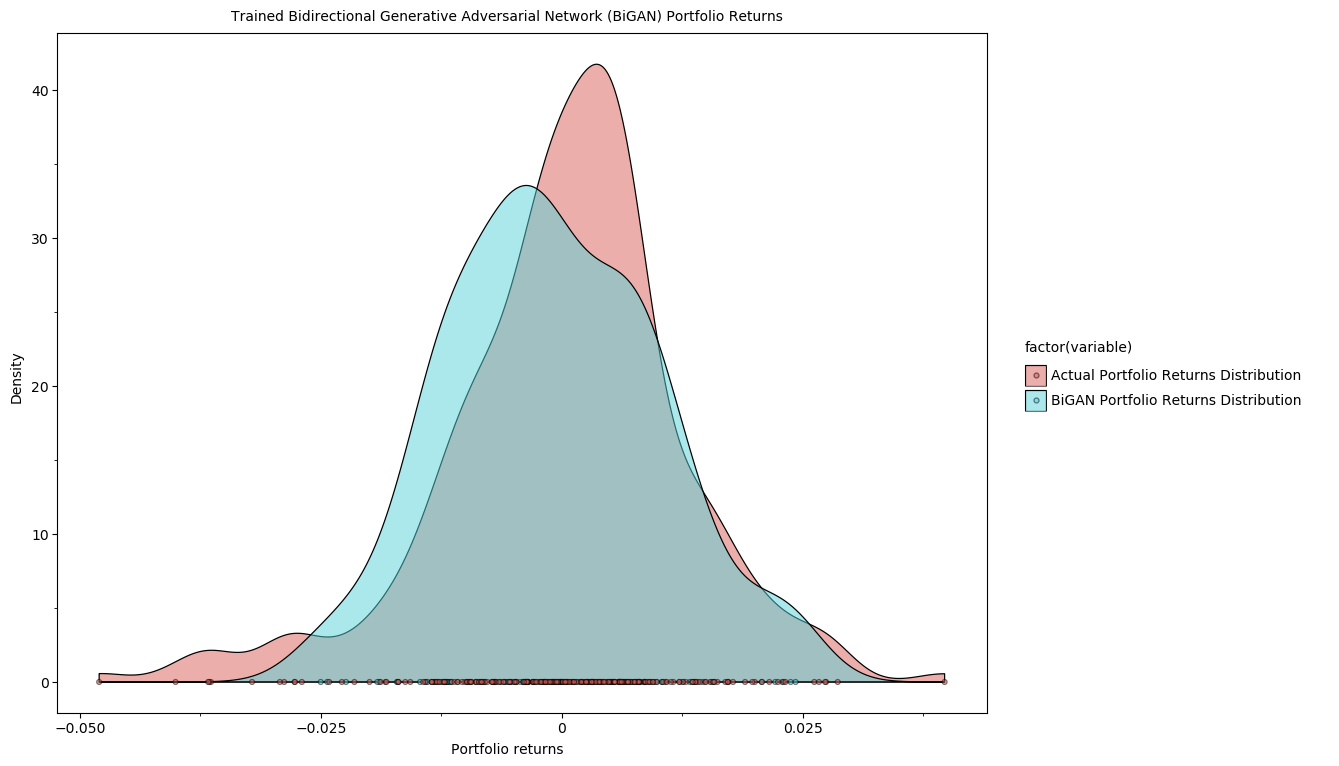

<ggplot: (8727365480623)>

In [62]:
num_sim = 100
x_mean = np.zeros(shape=num_sim)
with tf.device(device_name="/CPU:0"):
    for i in range(num_sim):
        x_mean[i] = np.average(
            a=(
                generator(
                    z=np.array(
                        object=[
                            np.random.uniform(low=-1.0, high=1.0, size=(num_encoding))
                        ]
                    )
                )[0]
                * std
            )
            + mean
        )

act_mean = np.zeros(shape=ret_data.shape[0])
for i in range(ret_data.shape[0]):
    act_mean[i] = np.average(a=(ret_data.iloc[i] * std) + mean)

plotnine.options.figure_size = (12, 9)
plot = (
    plotnine.ggplot(
        mapping=pd.melt(
            frame=pd.concat(
                objs=[
                    pd.DataFrame(
                        data=x_mean, columns=["BiGAN Portfolio Returns Distribution"]
                    ),
                    pd.DataFrame(
                        data=act_mean, columns=["Actual Portfolio Returns Distribution"]
                    ),
                ],
                axis=1,
            ).reset_index(drop=True)
        ).dropna(axis="index")
    )
    + plotnine.geom_density(
        mapping=plotnine.aes(
            x="value",
            fill="factor(variable)",
        ),
        alpha=0.5,
        color="black",
    )
    + plotnine.geom_point(
        mapping=plotnine.aes(x="value", y=0, fill="factor(variable)"),
        alpha=0.5,
        color="black",
    )
    + plotnine.xlab(xlab="Portfolio returns")
    + plotnine.ylab(ylab="Density")
    + plotnine.ggtitle(
        title="Trained Bidirectional Generative Adversarial Network (BiGAN) Portfolio Returns"
    )
    + plotnine.theme_matplotlib()
)
plot.save(filename="trained_bigan_sampler.png")
print(
    "The VaR at 1% estimate given by the BiGAN: {}%".format(
        100 * np.percentile(a=x_mean, axis=0, q=1)
    )
)
plot

/home/hamaad/.local/lib/python3.8/site-packages/plotnine/ggplot.py:727: PlotnineWarning: Saving 12 x 9 in image.
/home/hamaad/.local/lib/python3.8/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: untrained_bigan_sampler.png
/home/hamaad/.local/lib/python3.8/site-packages/plotnine/themes/theme.py:250: MatplotlibDeprecationWarning: 
The examples.directory rcparam was deprecated in Matplotlib 3.0 and will be removed in 3.2. In the future, examples will be found relative to the 'datapath' directory.
/home/hamaad/.local/lib/python3.8/site-packages/plotnine/themes/theme.py:250: MatplotlibDeprecationWarning: 
The examples.directory rcparam was deprecated in Matplotlib 3.0 and will be removed in 3.2. In the future, examples will be found relative to the 'datapath' directory.


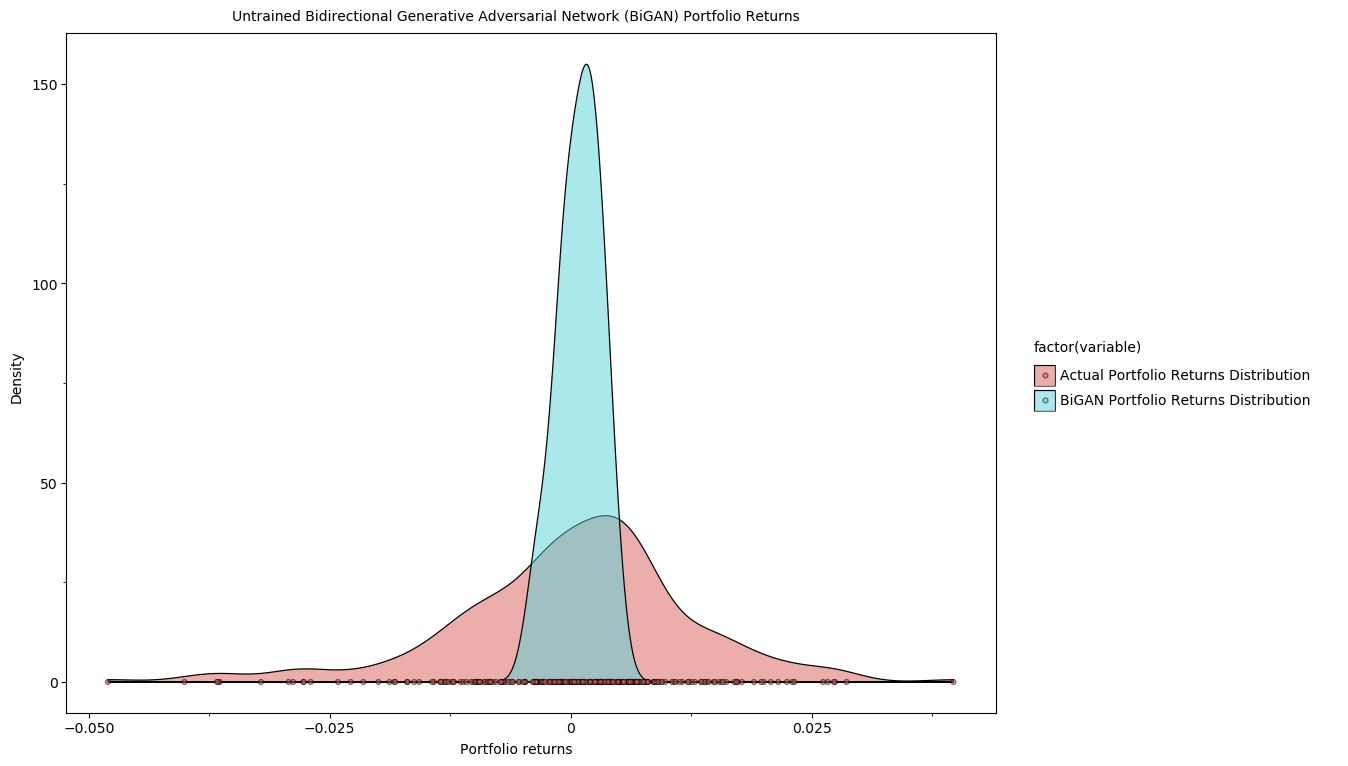

<ggplot: (8768551972810)>

In [176]:
untrained_generator = BidirectionalGenerativeAdversarialNetworkGenerator(
    num_hidden=num_hidden, num_inputs=num_inputs
)

untrained_x = np.zeros(shape=(num_sim, num_inputs))
untrained_x_mean = np.zeros(shape=num_sim)
for i, xi in enumerate(noise):
    untrained_x[i, :] = (untrained_generator(z=np.array([xi]))[0] * std) + mean
    untrained_x_mean[i] = np.average(a=untrained_x[i, :])

plotnine.options.figure_size = (12, 9)
plot = (
    plotnine.ggplot(
        mapping=pd.melt(
            frame=pd.concat(
                objs=[
                    pd.DataFrame(
                        data=untrained_x_mean,
                        columns=["BiGAN Portfolio Returns Distribution"],
                    ),
                    pd.DataFrame(
                        data=act_mean, columns=["Actual Portfolio Returns Distribution"]
                    ),
                ],
                axis=1,
            ).reset_index(drop=True)
        ).dropna(axis="index")
    )
    + plotnine.geom_density(
        mapping=plotnine.aes(x="value", fill="factor(variable)"),
        alpha=0.5,
        color="black",
    )
    + plotnine.geom_point(
        mapping=plotnine.aes(x="value", y=0, fill="factor(variable)"),
        alpha=0.5,
        color="black",
    )
    + plotnine.xlab(xlab="Portfolio returns")
    + plotnine.ylab(ylab="Density")
    + plotnine.ggtitle(
        title="Untrained Bidirectional Generative Adversarial Network (BiGAN) Portfolio Returns"
    )
    + plotnine.theme_matplotlib()
)
plot.save(filename="untrained_bigan_sampler.png")
plot

## Conclusion

Before we conclude the article let's have a look at the portfolio returns distribution sampled from an untrained BiGAN. 

![](untrained_bigan_sampler.png)

It is clear from the above graph that the untrained BiGAN's sampled portfolio returns distribution is remarkably different from the actual portfolio returns distribution. This is, as we can imagine, to be expected.

Contrast this with a trained BiGAN: The following graph will clearly show the value of GAN type models for market risk management as we have arrived at this learnt portfolio returns distribution without having to rely on a possibly incorrect assumption with regards to the actual portfolio returns distribution such as a multidimensional Gaussian distribution.

Note that we perhaps should use an evolutionary algorithm or a reinforcement learner to automatically learn the appropriate GAN or BiGAN architecture: Perhaps that shall be a topic for a future article.

![](trained_bigan_sampler.png)

Finally we update the VaR estimate table for using different market risk management methods as below. We can see that the VaR estimate provided by the BiGAN is similar, if not exactly the same, to the ones provided by the other market risk management methods. This provides us with a good sanity check with regards to using the BiGAN for market risk management in that it provides competitive results with respect to well established existing market risk management methods.

| VaR Method    | 1% VaR | 
| :------------- |-------------:|
| Variance-covariance | -2.87% | 
| Historical simulation | -3.65%  |
| Monte Carlo simulation | -2.63%  |
| Bidirectional Generative Adversarial Network | -4.42%  |

The portfolio of 5 stocks we had to work with was not particularly complicated compared to potentially having portfolios where we might have derivatives or other portfolio components. Arriving at the correct portfolio returns distribution of a potentially complicated portfolio is a problem that has been shown can be solved via deep learning specifically the BiGAN. This result can be useful for market risk management and any other different problem space where we need to generate samples from a potentially complex, and perhaps unknown, distribution. 

There will potentially be a follow up article of mine where we look at a complicated backtesting scenario, i.e., validating that market risk management VaR type estimates provided by BiGAN is appropriate for future portfolio returns distributions that we have not seen, and perhaps using more complicated portfolios. The aim of this article of mine was to clearly show that a trained BiGAN can be used for market risk management VaR estimation for a given portfolio.

## References

1. Goodfellow, I., Bengio, Y. and Courville A. (2016). Deep Learning (MIT Press).
2. Geron, A. (2017). Hands-On Machine Learning with Scikit-Learn & Tensorflow (O'Reilly).
3. Kingma, D. P., and Welling M. (2014). Auto-Encoding Variational Bayes (https://arxiv.org/abs/1312.6114).
4. http://scikit-learn.org/stable/#
5. https://towardsdatascience.com/learning-rate-schedules-and-adaptive-learning-rate-methods-for-deep-learning-2c8f433990d1
6. https://stackoverflow.com/questions/42177658/how-to-switch-backend-with-keras-from-tensorflow-to-theano
7. https://blog.keras.io/building-autoencoders-in-keras.html
8. https://keras.io
9. Chollet, F. (2018). Deep Learning with Python (Manning).
10. Hull, John C. (2010). Risk Management and Financial Institutions (Pearson).
11. https://towardsdatascience.com/automatic-feature-engineering-using-deep-learning-and-bayesian-inference-application-to-computer-7b2bb8dc7351
12. https://towardsdatascience.com/automatic-feature-engineering-using-generative-adversarial-networks-8e24b3c16bf3
13. Donahue, J., Krähenbühl, P. and Darrell, T. (2017). Adversarial Feature Learning (https://arxiv.org/pdf/1605.09782).
14. https://github.com/eriklindernoren/Keras-GAN